# Imports

In [203]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit (check versions)
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit Aer version {qiskit_aer.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")
print(f"Qiskit IBM runtime version {qiskit_ibm_runtime.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit

# General Imports
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, Pauli, DensityMatrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    amplitude_damping_error
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 1.3.2
Qiskit Aer version 0.17.0
Qiskit algorithms version 0.3.1
Qiskit IBM runtime version 0.35.0


# Question 4 - Quantum Comparator

## Testing

In [204]:
def test(qc, n):

    # Get the final state
    state = Statevector(qc)

    # Check the results
    ok = True
    for index, coeff in enumerate(state):

        # The coefficient should just be zero if some ancilla is not zero
        if index >= 2**(2*n):
            if np.abs(coeff) != 0:
                print(f"Error in ancillas for x = {x} and y = {y}")
                ok = False

        # The coefficient should change sign as appropriate
        else:
            index = f"{index:0{nq}b}"
            x = int(index[-n:][::-1], 2)
            y = int(index[-2*n:-n][::-1], 2)

            # print(index, x, y, coeff)

            # Detect failure
            if (x > y and coeff.real >= 0) or (x <= y and coeff.real <= 0):
                print(f"Error in sign for x = {x} and y = {y}")
                ok = False
    
    return state, ok

## Version 1

Circuit for n = 4
Toffoli gates:  104


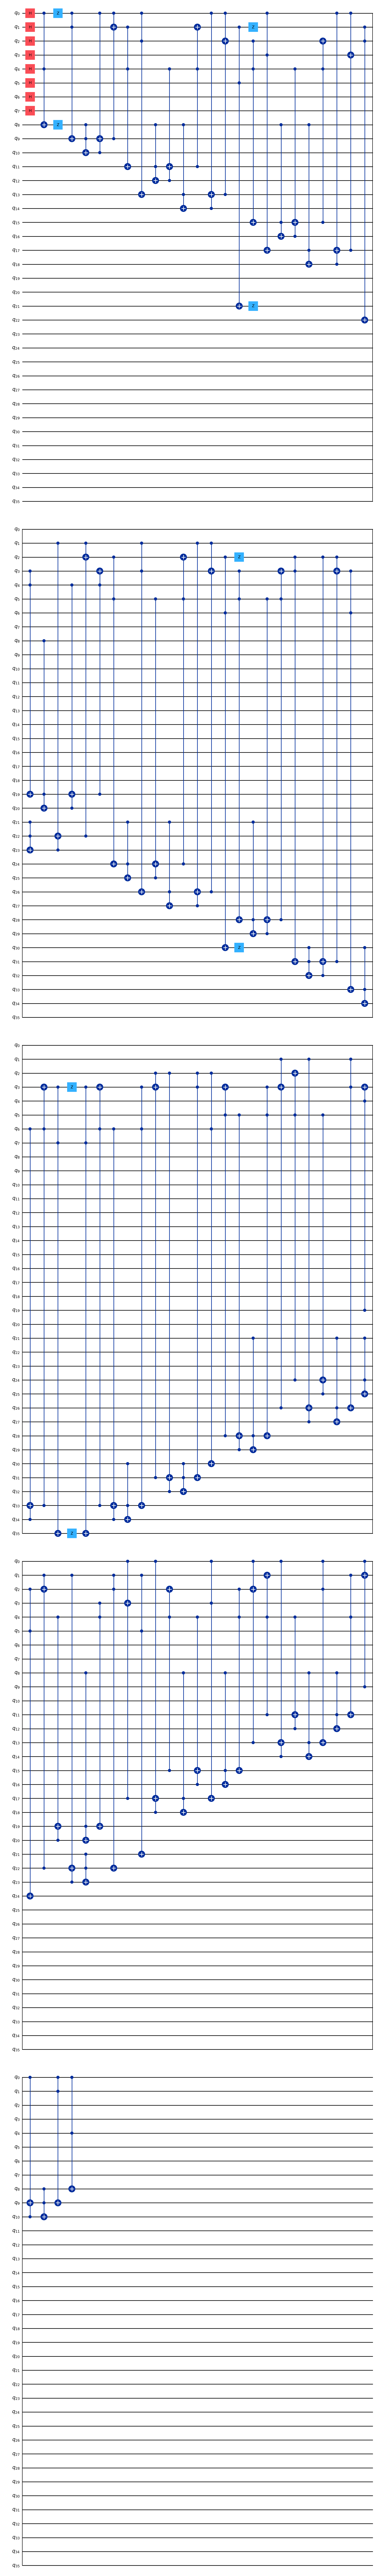

In [205]:
# ----- PARAMETERS -----
n = 4
m = 2 * n**2 - n

nq = 2 * n + m

# ----- SETUP -----
qc = QuantumCircuit(nq)

# Create a superposition of all states, to test that our algorithm works
for i in range(2*n):
    qc.h(i)

# Next ancilla qubit that has not been used yet
anc = 2*n

# Current 11 test
anc11 = -1

# Toffoli to revert at the end
revert = []



# ----- ALGORITHM -----
for i in range(n):

    # Get qubit indexes
    xi = i
    yi = i+n

    # Compare x_i with y_i
    qc.ccx(xi, yi, anc)
    qc.z(xi)
    qc.z(anc)

    # Accounting
    revert += [(xi, yi, anc)]
    anc11 = anc
    anc += 1

    # Set next qubits to zero if comparison terminated (remember j > i)
    for j in range(i+1, n):
        xj = j
        yj = j+n

        # Set all future xj = 0 if xi = 1 and yi is not 1
        qc.ccx(xi, xj, anc)
        revert += [(xi, xj, anc)]
        anc += 1

        qc.ccx(anc11, anc-1, anc)
        revert += [(anc11, anc-1, anc)]
        anc += 1

        qc.ccx(xi, anc-1, anc-2)
        revert += [(xi, anc-1, anc-2)]

        qc.ccx(xi, anc-2, xj)
        revert += [(xi, anc-2, xj)]

        
        # Set all future xj = 0 if yi = 1 and xi is not 1
        qc.ccx(yi, xj, anc)
        revert += [(yi, xj, anc)]
        anc += 1

        qc.ccx(anc11, anc-1, anc)
        revert += [(anc11, anc-1, anc)]
        anc += 1

        qc.ccx(yi, anc-1, anc-2)
        revert += [(yi, anc-1, anc-2)]

        qc.ccx(yi, anc-2, xj)
        revert += [(yi, anc-2, xj)]



# Revert Toffoli gates
for item in revert[::-1]:
    qc.ccx(item[0], item[1], item[2])



# ----- VISUALIZATION -----
print(f"Circuit for n = {n}")
print("Toffoli gates: ", len(revert) * 2)
qc.draw('mpl')

In [206]:
state, ok = test(qc, n)

print(f"Circuit is {'OK!' if ok else "Not OK :("}\n")

print("Final state is:")
state.draw("latex")

MemoryError: Unable to allocate 1.00 TiB for an array with shape (68719476736,) and data type complex128

## Version 2

Circuit for n = 2


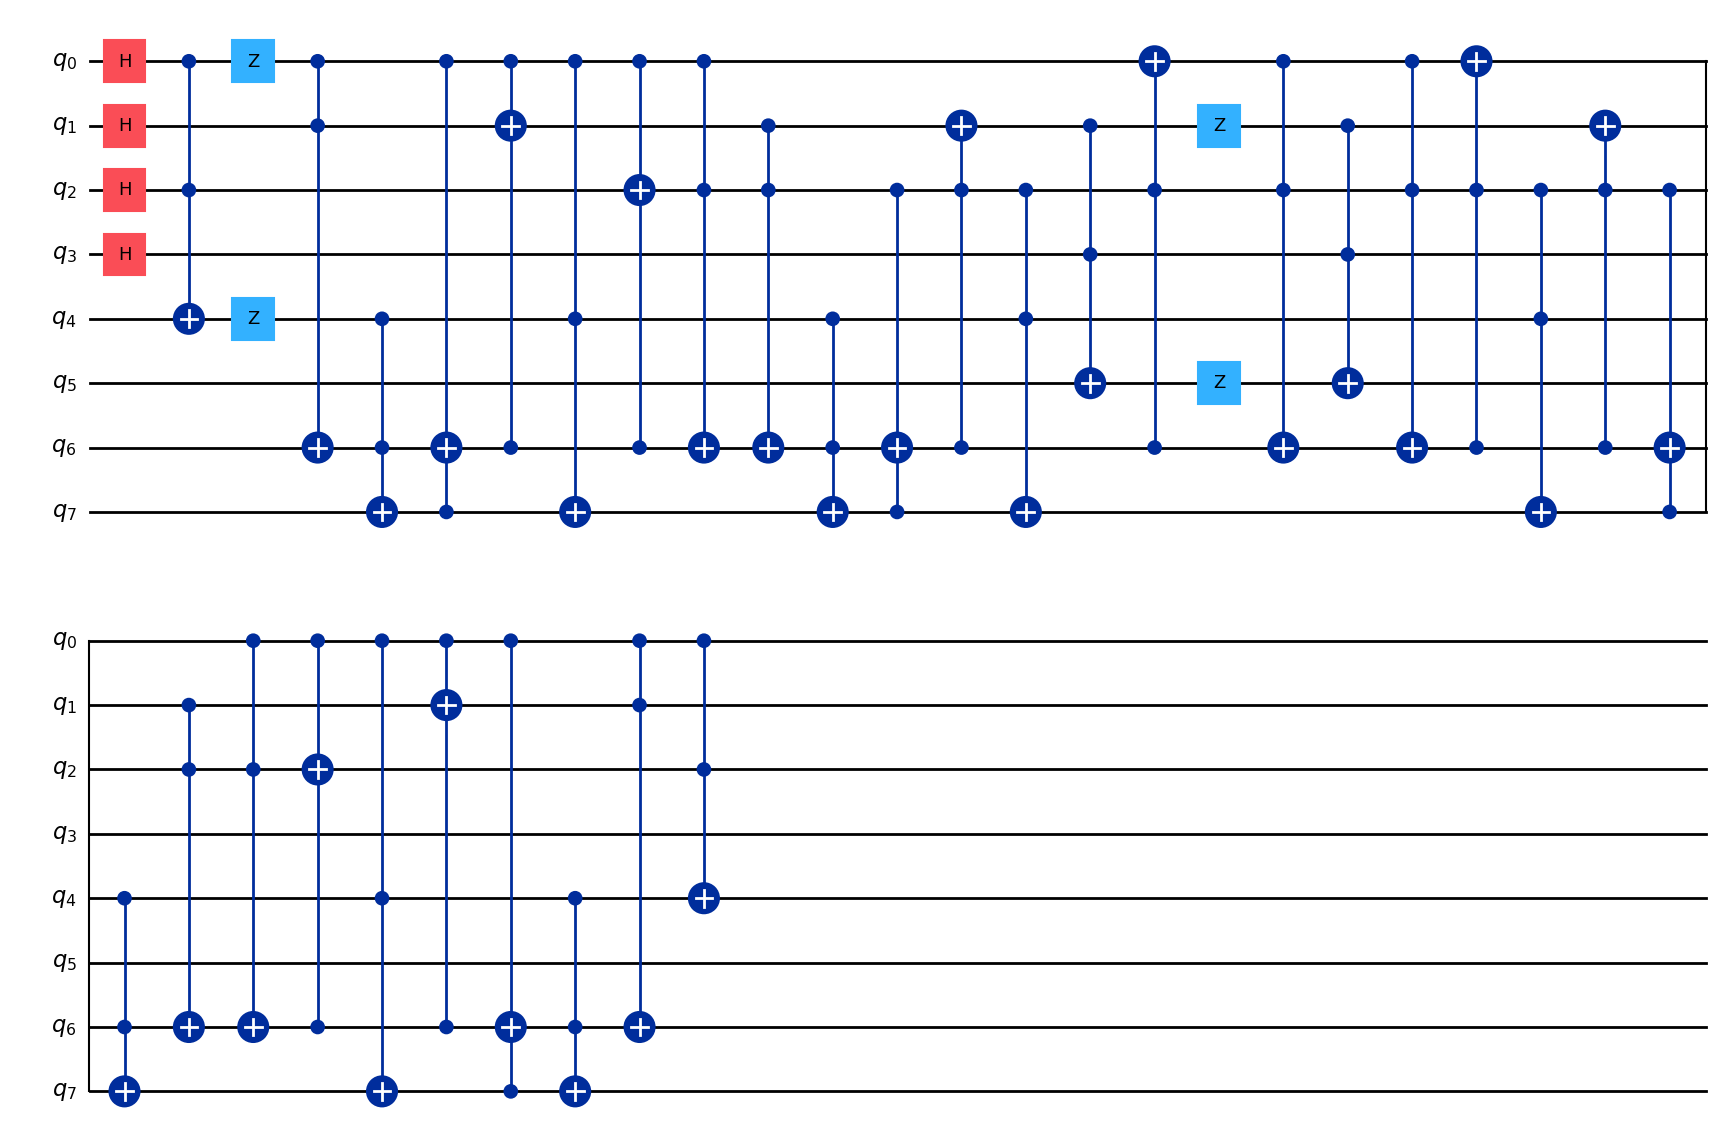

In [ ]:
# ----- PARAMETERS -----
n = 2
m = n + 2

nq = 2 * n + m

# ----- SETUP -----
qc = QuantumCircuit(nq)

# Create a superposition of all states, to test that our algorithm works
for i in range(2*n):
    qc.h(i)

# Position of the current 11 test
anc11 = 2*n

# Next ancilla qubit that has not been used yet
anc = 3*n

# Toffoli to revert at the end of every termination step
revert = []


# ----- ALGORITHM -----
for i in range(n):

    # Get qubit indexes
    xi = i
    yi = i+n

    # Compare x_i with y_i
    qc.ccx(xi, yi, anc11)
    revert += [(xi, yi, anc11)]
    qc.z(xi)

    qc.z(anc11)

    # Set next qubits to zero if comparison terminated (remember j > i)
    for j in range(i+1, n):
        xj = j
        yj = j+n

        # Set all future xj = 0 if xi = 1 and yi is not 1
        qc.ccx(xi, xj, anc)
        revert += [(xi, xj, anc)]
        anc += 1

        qc.ccx(anc11, anc-1, anc)
        revert += [(anc11, anc-1, anc)]
        anc += 1

        qc.ccx(xi, anc-1, anc-2)
        revert += [(xi, anc-1, anc-2)]

        qc.ccx(xi, anc-2, xj)
        revert += [(xi, anc-2, xj)]

        
        # Ancilla-clearing step
        qc.ccx(xi, anc11, anc-1)
        revert += [(xi, anc11, anc-1)]

        qc.ccx(xi, anc-2, yi)
        revert += [(xi, anc-2, yi)]
        
        qc.ccx(xi, yi, anc-2)
        revert += [(xi, yi, anc-2)]

        anc = 3*n

        
        # Set all future xj = 0 if yi = 1 and xi is not 1
        qc.ccx(yi, xj, anc)
        revert += [(yi, xj, anc)]
        anc += 1

        qc.ccx(anc11, anc-1, anc)
        revert += [(anc11, anc-1, anc)]
        anc += 1

        qc.ccx(yi, anc-1, anc-2)
        revert += [(yi, anc-1, anc-2)]

        qc.ccx(yi, anc-2, xj)
        revert += [(yi, anc-2, xj)]
        
        # Ancilla-clearing step
        qc.ccx(yi, anc11, anc-1)
        revert += [(yi, anc11, anc-1)]

        qc.ccx(yi, anc-2, xi)
        revert += [(yi, anc-2, xi)]
        
        qc.ccx(yi, xi, anc-2)
        revert += [(yi, xi, anc-2)]

        anc = 3*n
    
    anc11 += 1


# Revert Toffoli gates
for item in revert[::-1]:
    qc.ccx(item[0], item[1], item[2])



# ----- VISUALIZATION -----
print(f"Circuit for n = {n}")
qc.draw('mpl')

In [ ]:
state, ok = test(qc, n)

print(f"Circuit is {'OK!' if ok else "Not OK :("}\n")

print("Final state is:")
state.draw("latex")

Error in sign for x = 2 and y = 2
Circuit is Not OK :(

Final state is:


<IPython.core.display.Latex object>